# **Предсказание оттока пользователей**

Ромадин Иван  
DLS (семестр 1, весна 2023), продвинутый поток   

*2023-03-27*

***

##  Описание задачи

#### Проблема

Классифицировать клиентов склонных прекратить пользование услугами компании. 

#### Задача

Смоделировать повередение клиентов на обучающей выборке и предсказать вероятнось оттока для каждого клиента из проверочной выборки.

#### Данные

1. Обучающая выборка — [train.csv](https://drive.google.com/file/d/1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K/view?usp=share_link)
2. Проверочная выборка — [test.csv](https://drive.google.com/file/d/1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r/view?usp=share_link[submission.csv](https://drive.google.com/file/d/199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y/view?usp=share_link)
3. Пример решения — [submission.csv](https://drive.google.com/file/d/199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y/view?usp=share_link)

#### Ключевая метрика

Для оценки эффективности предсказаний используется метрика **ROC-AUC**. Критерии оценки (скоринг на проверочной выборке):  
1\. $1.00 \geqslant score \geqslant 0.84$ --- 5 баллов;  
2\. $0.84 > score \geqslant 0.77$ --- 4 балла;  
3\. $0.77 > score \geqslant 0.70$ --- 3 балла;  
4\. $0.70 > score \geqslant 0.65$ --- 2 балла;  
5\. $0.65 > score \geqslant 0.6$ --- 1 балл;  
6\. $0.60 > score$ --- 0 баллов  

#### Дополнительные условия

- [ ] Провести исследовательский анализ данных;
- [ ] Отнормировать численные и закодировать категориальные признаки;
- [ ] Применить линейные модели;
- [ ] Применить градентный бустинг;
- [ ] Используя кросс-валидацию подобрать оптимальные гиперпараметры;

***

## Предустановки

#### Импорт библиотек

In [1]:
# базовые библиотеки
import os
import re
import warnings

import matplotlib
import numpy as np
import pandas as pd
import phik
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

#### Настройки ноутбука

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_style("dark", {"axes.facecolor": ".95"})


plt.rcParams["figure.figsize"] = (8, 5)
%config InlineBackend.figure_format = "retina"
%matplotlib inline
warnings.filterwarnings("ignore")

#### Функции

In [3]:
def general_info(data):
    """Takes in pandas dataframe and returns table with the main statistics."""

    df = pd.DataFrame()
    df["missing"] = data.isna().sum().sort_values(ascending=False)
    df["%_missing"] = (data.isna().sum() / data.isna().count()).sort_values(
        ascending=False
    )
    df["%_missing"] = pd.Series(
        ["{:.3%}".format(x) for x in df["%_missing"]], index=df.index
    )
    df["value_sample"] = data.sample().T
    df["dtype"] = data.dtypes
    describe = data.describe(include="all").round(3).T
    df = df.merge(describe, left_on=df.index, right_on=describe.index)
    df["count"] = df["count"].astype(int)
    df.rename({"key_0": "column_name", "top": "mode"}, inplace=True, axis=1)
    df["unique"] = pd.Series(
        [data[column].nunique() for column in df["column_name"]], index=df.index
    )
    df.fillna("", inplace=True)
    return df

In [4]:
def optimize_dtypes(
    df, float_cols=False, int_cols=False, float_format=np.float32, int_format=np.int16
):
    "Тakes in and updates it with optimal data types."

    if float_cols == True:
        df[float_cols] = df[float_cols].astype(float_format)

    if int_cols == True:
        df[int_cols] = df[int_cols].astype(int_format)

#### Имена признаков

In [5]:
# Числовые признаки
num_cols = ["ClientPeriod", "MonthlySpending", "TotalSpent"]

# Категориальные признаки
cat_cols = [
    "Sex",
    "IsSeniorCitizen",
    "HasPartner",
    "HasChild",
    "HasPhoneService",
    "HasMultiplePhoneNumbers",
    "HasInternetService",
    "HasOnlineSecurityService",
    "HasOnlineBackup",
    "HasDeviceProtection",
    "HasTechSupportAccess",
    "HasOnlineTV",
    "HasMovieSubscription",
    "HasContractPhone",
    "IsBillingPaperless",
    "PaymentMethod",
]

target = "Churn"

***

## Предварительная обработка

### Чтение данных

In [6]:
path = "../data/train.csv"
train = pd.read_csv(path)
train.sample(3)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
666,70,49.85,3370.2,Female,0,Yes,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,Yes,Two year,Yes,Bank transfer (automatic),0
359,48,111.80,5443.65,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
721,70,105.35,7511.9,Male,1,Yes,No,Yes,No,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Credit card (automatic),0


In [7]:
test = pd.read_csv("../data/test.csv")
test.sample(3)

sub_example = pd.read_csv("../data/submission.csv")
sub_example.sample(3)

,Id,Churn
565,565,0.5
1382,1382,0.5
1126,1126,0.5


### Общая информация 

In [8]:
# кастомная функция для отображения общей информации
general_info(train)

,column_name,missing,%_missing,value_sample,dtype,count,unique,mode,freq,mean,std,min,25%,50%,75%,max
0,ClientPeriod,0,0.000%,9,int64,5282,73,,,32.397,24.55,0.0,9.0,29.0,55.0,72.0
1,MonthlySpending,0,0.000%,80.55,float64,5282,1468,,,64.925,30.176,18.25,35.463,70.4,90.05,118.75
2,PaymentMethod,0,0.000%,Electronic check,object,5282,4,Electronic check,1786,,,,,,,
3,IsBillingPaperless,0,0.000%,No,object,5282,2,Yes,3148,,,,,,,
4,HasContractPhone,0,0.000%,Month-to-month,object,5282,3,Month-to-month,2920,,,,,,,
5,HasMovieSubscription,0,0.000%,No,object,5282,3,No,2081,,,,,,,
6,HasOnlineTV,0,0.000%,No,object,5282,3,No,2099,,,,,,,
7,HasTechSupportAccess,0,0.000%,No,object,5282,3,No,2604,,,,,,,
8,HasDeviceProtection,0,0.000%,Yes,object,5282,3,No,2317,,,,,,,
9,HasOnlineBackup,0,0.000%,Yes,object,5282,3,No,2332,,,,,,,


### Пропущенные значения

Признак `TotalSpent` должен быть числовым, однако отображается как объект. При этом, самое частое значение признака (*mode*) — пустая строка, которая появляется 9 раз во всей тренировочной выборке.

In [9]:
train["TotalSpent"].value_counts()[:5]

         9
20.2     9
19.75    8
20.05    6
19.65    6
Name: TotalSpent, dtype: int64

Принудительно обратим признак в числовой и изучим эту часть выборки подробнее:

In [10]:
train["TotalSpent"] = pd.to_numeric(train["TotalSpent"], errors="coerce")
# показать объекты с отсутствущими значениями
train_missing = train[train.isna().any(axis=1)]
train_missing

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Примечательно что у всех объектов с пропущеннымим значениями признака `TotalSpent` значение `ClientPeriod` равно нулю. Логично предположить, что для этих клиентов первый расчетный переиод ещё не наступил, потому `TotalSpent` и пустует. Исходя из этого предположения, допустим что для всех `ClientPeriod` == 0 значение `TotlaSpent` будет равно текущему `MonthlySpending`.

In [11]:
train.loc[train_missing.index, "TotalSpent"] = train.loc[
    train_missing.index, "MonthlySpending"
]

Повторим то же самое с проверочной выборкой: 

In [12]:
test["TotalSpent"] = pd.to_numeric(test["TotalSpent"], errors="coerce")

test_missing = test[test.isna().any(axis=1)]
test_missing

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,NaN,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


In [13]:
test.loc[test_missing.index, "TotalSpent"] = test.loc[
    test_missing.index, "MonthlySpending"
]

### Кодирование бинарных признаков

Многие категориальные признаки содержат 3 уникальных значения, хотя есть ощущение что ответ должен быть бинарным. Проверим уникальные значения:

In [14]:
for col in cat_cols:
    vals = train[col].unique()
    print(f"{col:<30s}\t{vals}")

Sex                           	['Male' 'Female']
IsSeniorCitizen               	[0 1]
HasPartner                    	['Yes' 'No']
HasChild                      	['Yes' 'No']
HasPhoneService               	['Yes' 'No']
HasMultiplePhoneNumbers       	['No' 'Yes' 'No phone service']
HasInternetService            	['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService      	['No internet service' 'No' 'Yes']
HasOnlineBackup               	['No internet service' 'No' 'Yes']
HasDeviceProtection           	['No internet service' 'No' 'Yes']
HasTechSupportAccess          	['No internet service' 'Yes' 'No']
HasOnlineTV                   	['No internet service' 'No' 'Yes']
HasMovieSubscription          	['No internet service' 'No' 'Yes']
HasContractPhone              	['One year' 'Two year' 'Month-to-month']
IsBillingPaperless            	['No' 'Yes']
PaymentMethod                 	['Mailed check' 'Credit card (automatic)' 'Electronic check'
 'Bank transfer (automatic)']


Действительно, значения `No internet service` и `No phone service` могут быть логически приравнены к `False`, а признаки, содержащие эти значения, могут считаться бинарными.

#### Обучающая выборка

In [15]:
train = (
    train.rename({"Sex": "IsMale"}, axis=1)
    .replace(["Male", "Yes"], 1)
    .replace(["Female", "No", "No internet service", "No phone service"], 0)
)

# обновить название признака
cat_cols[0] = "IsMale"

# провести проверку
for col in cat_cols:
    vals = train[col].unique()
    print(f"{col:<30s}\t{vals}")

IsMale                        	[1 0]
IsSeniorCitizen               	[0 1]
HasPartner                    	[1 0]
HasChild                      	[1 0]
HasPhoneService               	[1 0]
HasMultiplePhoneNumbers       	[0 1]
HasInternetService            	[0 'Fiber optic' 'DSL']
HasOnlineSecurityService      	[0 1]
HasOnlineBackup               	[0 1]
HasDeviceProtection           	[0 1]
HasTechSupportAccess          	[0 1]
HasOnlineTV                   	[0 1]
HasMovieSubscription          	[0 1]
HasContractPhone              	['One year' 'Two year' 'Month-to-month']
IsBillingPaperless            	[0 1]
PaymentMethod                 	['Mailed check' 'Credit card (automatic)' 'Electronic check'
 'Bank transfer (automatic)']


#### Проверочная выборка

In [16]:
test = (
    test.rename({"Sex": "IsMale"}, axis=1)
    .replace(["Male", "Yes"], 1)
    .replace(["Female", "No", "No internet service", "No phone service"], 0)
)

for col in cat_cols:
    vals = test[col].unique()
    print(f"{col:<30s}\t{vals}")

IsMale                        	[1 0]
IsSeniorCitizen               	[0 1]
HasPartner                    	[1 0]
HasChild                      	[0 1]
HasPhoneService               	[1 0]
HasMultiplePhoneNumbers       	[1 0]
HasInternetService            	['DSL' 'Fiber optic' 0]
HasOnlineSecurityService      	[1 0]
HasOnlineBackup               	[0 1]
HasDeviceProtection           	[0 1]
HasTechSupportAccess          	[0 1]
HasOnlineTV                   	[0 1]
HasMovieSubscription          	[0 1]
HasContractPhone              	['One year' 'Month-to-month' 'Two year']
IsBillingPaperless            	[0 1]
PaymentMethod                 	['Credit card (automatic)' 'Electronic check' 'Bank transfer (automatic)'
 'Mailed check']


### Косметические улучшения

Значения столбца `PaymentMethod` содержит подразделение на автоматический и мануальный способ оплаты. Интуиция подсказывает, что может оказаться полезным выделить эту информацию в отдельный признак.

In [17]:
f = lambda x: 1 if "automatic" in x else 0

train["AutomaticPayment"] = train["PaymentMethod"].apply(f)
test["AutomaticPayment"] = test["PaymentMethod"].apply(f)

cat_cols.append("AutomaticPayment")

train["HasInternetService"].replace(0, "No", inplace=True)
test["HasInternetService"].replace(0, "No", inplace=True)

Заменим оставшиеся значения оставшихся категориальных признаков более короткими записями, стандартизированными в общей стилистике датасета:

In [18]:
train.replace(
    {
        "One year": "OneYear",
        "Month-to-month": "MonthToMonth",
        "Two year": "TwoYears",
        "Credit card (automatic)": "CreditCard",
        "Electronic check": "ElectronicCheck",
        "Bank transfer (automatic)": "BankTransfer",
        "Mailed check": "MailedCheck",
        "Fiber optic": "FiberOptic",
    },
    inplace=True,
)

test.replace(
    {
        "One year": "OneYear",
        "Month-to-month": "MonthToMonth",
        "Two year": "TwoYears",
        "Credit card (automatic)": "CreditCard",
        "Electronic check": "ElectronicCheck",
        "Bank transfer (automatic)": "BankTransfer",
        "Mailed check": "MailedCheck",
        "Fiber optic": "FiberOptic",
    },
    inplace=True,
)

### One-hot кодирование

Поскольку для некторых моделей кодирование категориальных признаков необязательно, сохраним закодированный датафрейм в отдельную переменную.

#### Обучающая выборка

In [19]:
internet_service = pd.get_dummies(
    train["HasInternetService"], drop_first=True, prefix="InternetIs", prefix_sep=""
)

contract_type = pd.get_dummies(train["HasContractPhone"])
contract_type.columns = [col + "Contract" for col in contract_type.columns]

payment_method = pd.get_dummies(train["PaymentMethod"])
payment_method.columns = [col + "Payment" for col in payment_method.columns]

ohe = pd.concat([internet_service, contract_type, payment_method], axis=1)

In [20]:
train_ohe = pd.concat(
    [
        train.drop(["HasInternetService", "HasContractPhone", "PaymentMethod"], axis=1),
        ohe,
    ],
    axis=1,
)
train_ohe.head(3)

,ClientPeriod,MonthlySpending,TotalSpent,IsMale,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,AutomaticPayment,InternetIsFiberOptic,InternetIsNo,MonthToMonthContract,OneYearContract,TwoYearsContract,BankTransferPayment,CreditCardPayment,ElectronicCheckPayment,MailedCheckPayment
0,55,19.50,1026.35,1,0,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
1,72,25.85,1872.20,1,0,1,0,1,1,0,...,1,0,1,0,0,1,0,1,0,0
2,1,75.90,75.90,1,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0


#### Проверочная выборка

In [21]:
internet_service = pd.get_dummies(
    test["HasInternetService"], drop_first=True, prefix="InternetIs", prefix_sep=""
)

contract_type = pd.get_dummies(test["HasContractPhone"])
contract_type.columns = [col + "Contract" for col in contract_type.columns]

payment_method = pd.get_dummies(test["PaymentMethod"])
payment_method.columns = [col + "Payment" for col in payment_method.columns]

ohe = pd.concat([internet_service, contract_type, payment_method], axis=1)

In [22]:
test_ohe = pd.concat(
    [
        test.drop(["HasInternetService", "HasContractPhone", "PaymentMethod"], axis=1),
        ohe,
    ],
    axis=1,
)
test_ohe.head(3)

,ClientPeriod,MonthlySpending,TotalSpent,IsMale,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,AutomaticPayment,InternetIsFiberOptic,InternetIsNo,MonthToMonthContract,OneYearContract,TwoYearsContract,BankTransferPayment,CreditCardPayment,ElectronicCheckPayment,MailedCheckPayment
0,42,56.10,2386.85,1,0,1,0,1,1,1,...,1,0,0,0,1,0,0,1,0,0
1,29,98.50,3004.15,1,1,1,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
2,9,76.25,684.85,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0


***

## Исследовательский анализ данных

### Целевой признак

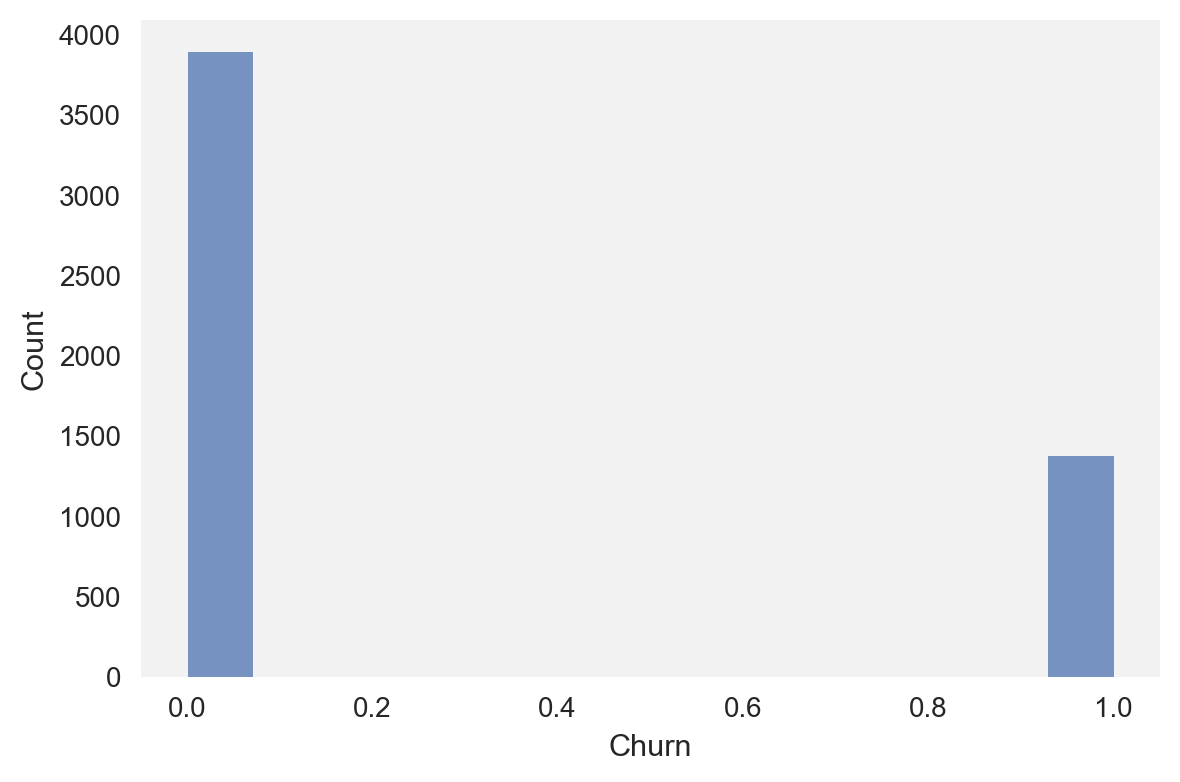

In [23]:
sns.displot(data=train, x="Churn", height=4, aspect=1.5);

Налицо явный дисбаланс классов. Для более эффективного обучения модели может пригодиться *up/oversampling*.

### Численные признаки

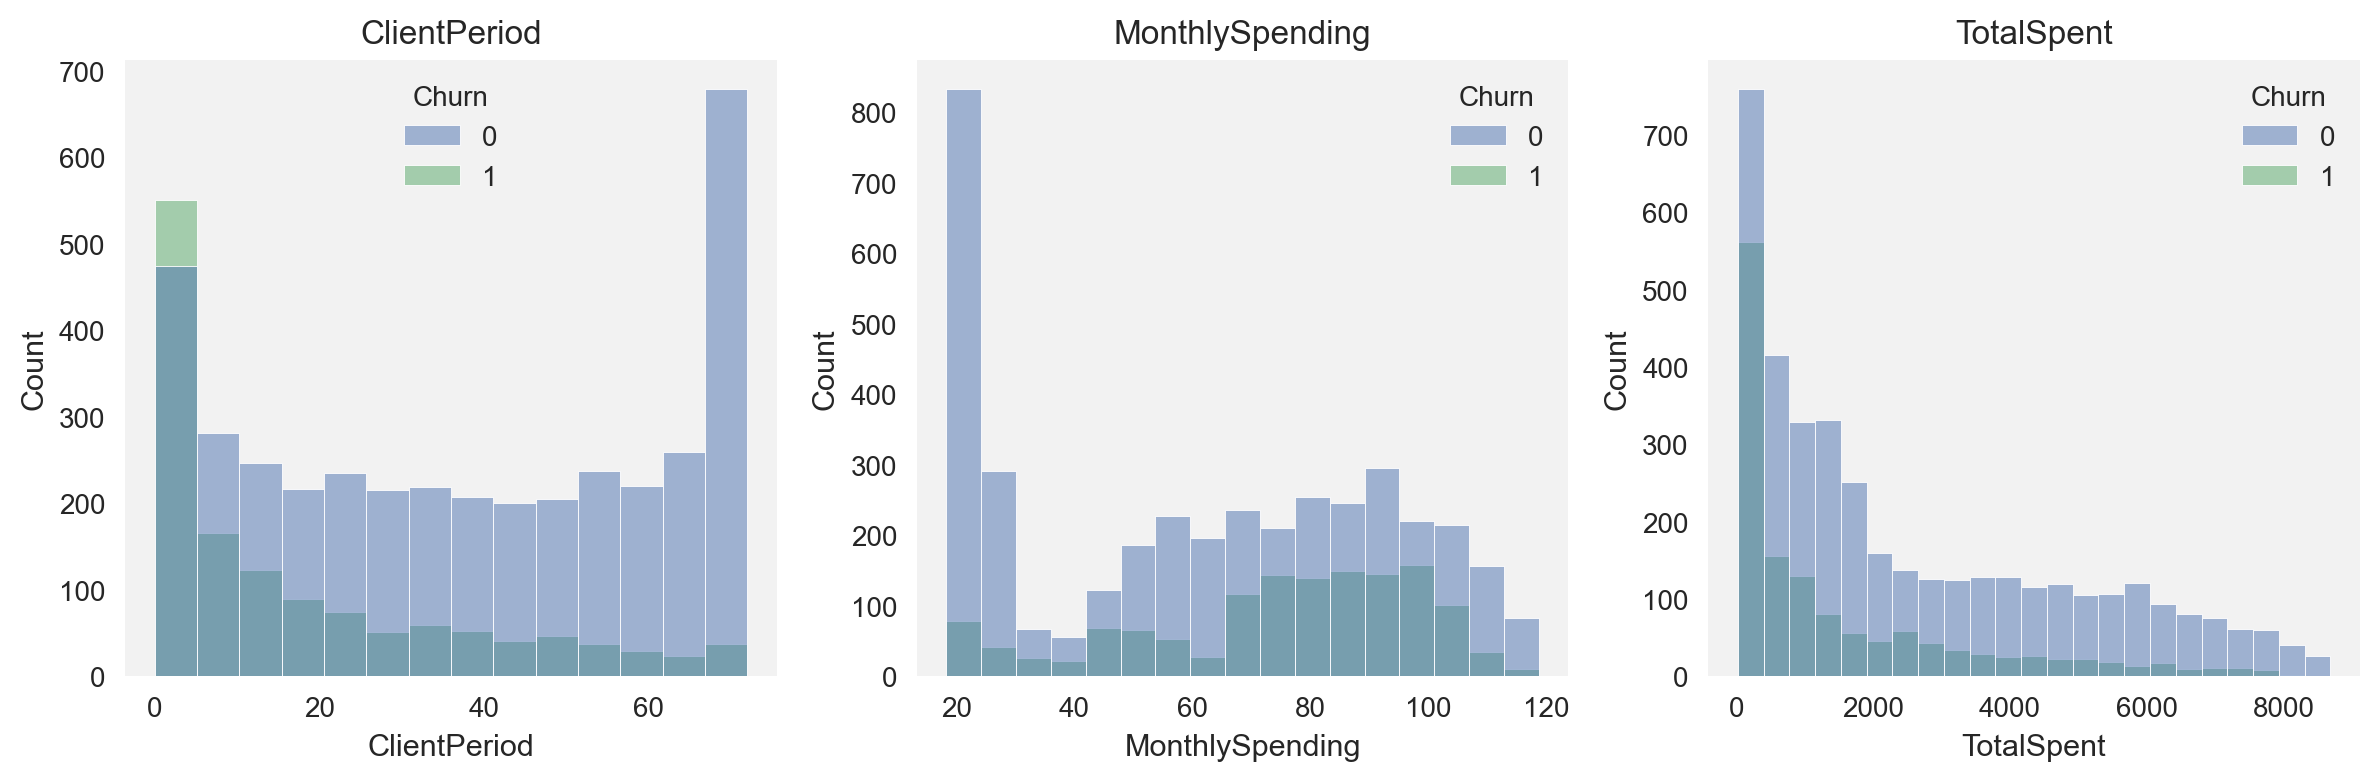

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, col in enumerate(num_cols):
    ax[i].set(title=col)
    sns.histplot(data=train, x=col, hue="Churn", ax=ax[i])

plt.tight_layout()

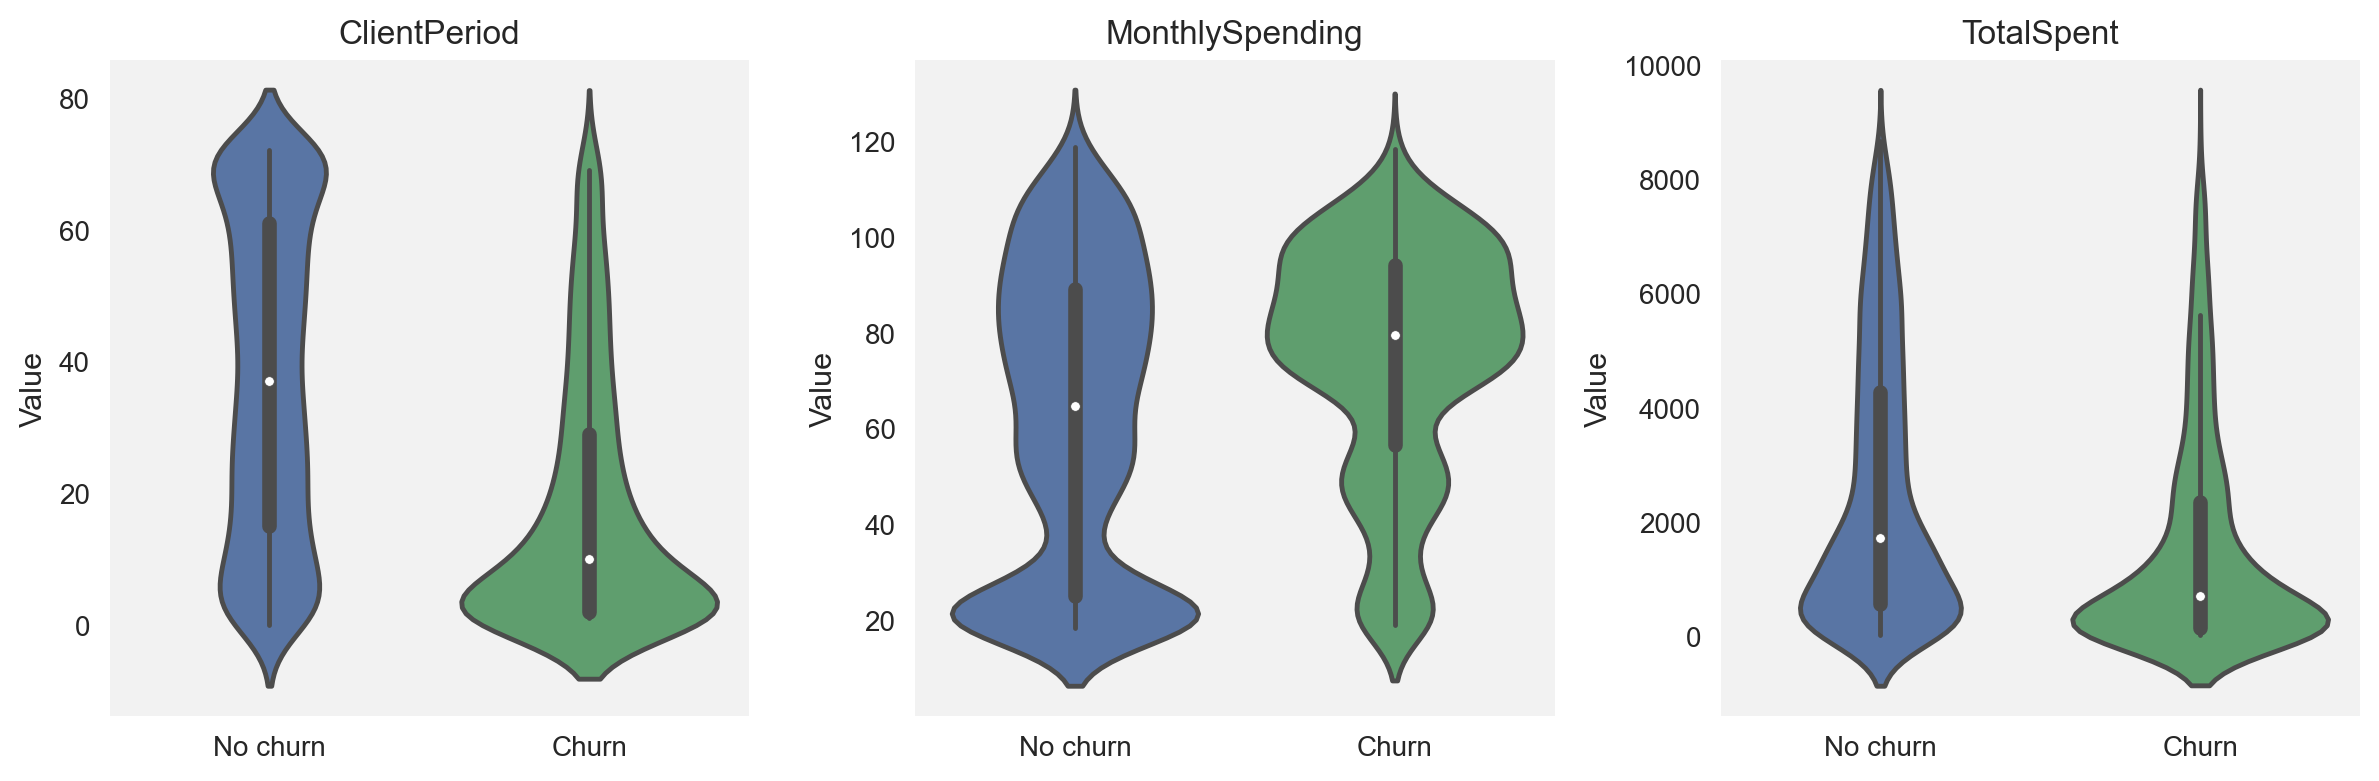

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, col in enumerate(num_cols):
    sns.violinplot(data=train, y=col, x="Churn", ax=ax[i])
    ax[i].set(title=col, xlabel="", ylabel="Value")
    ax[i].set_xticklabels(["No churn", "Churn"])

plt.tight_layout()

- На гистограмах признака `ClientPerieod` видно, что среди тех, кто отказался от услуг компании, есть явное смещение в сторону новых клиентов.  
- Также, можно обратить внимание на больший размер месячной оплаты (`MonthlySpending`) среди «оттекших» клиентов.
- На основе имеющихся данных можно сгенерировать новые признаки, которые будут в явной манере разделять эти тенденции.

### Бинарные признаки

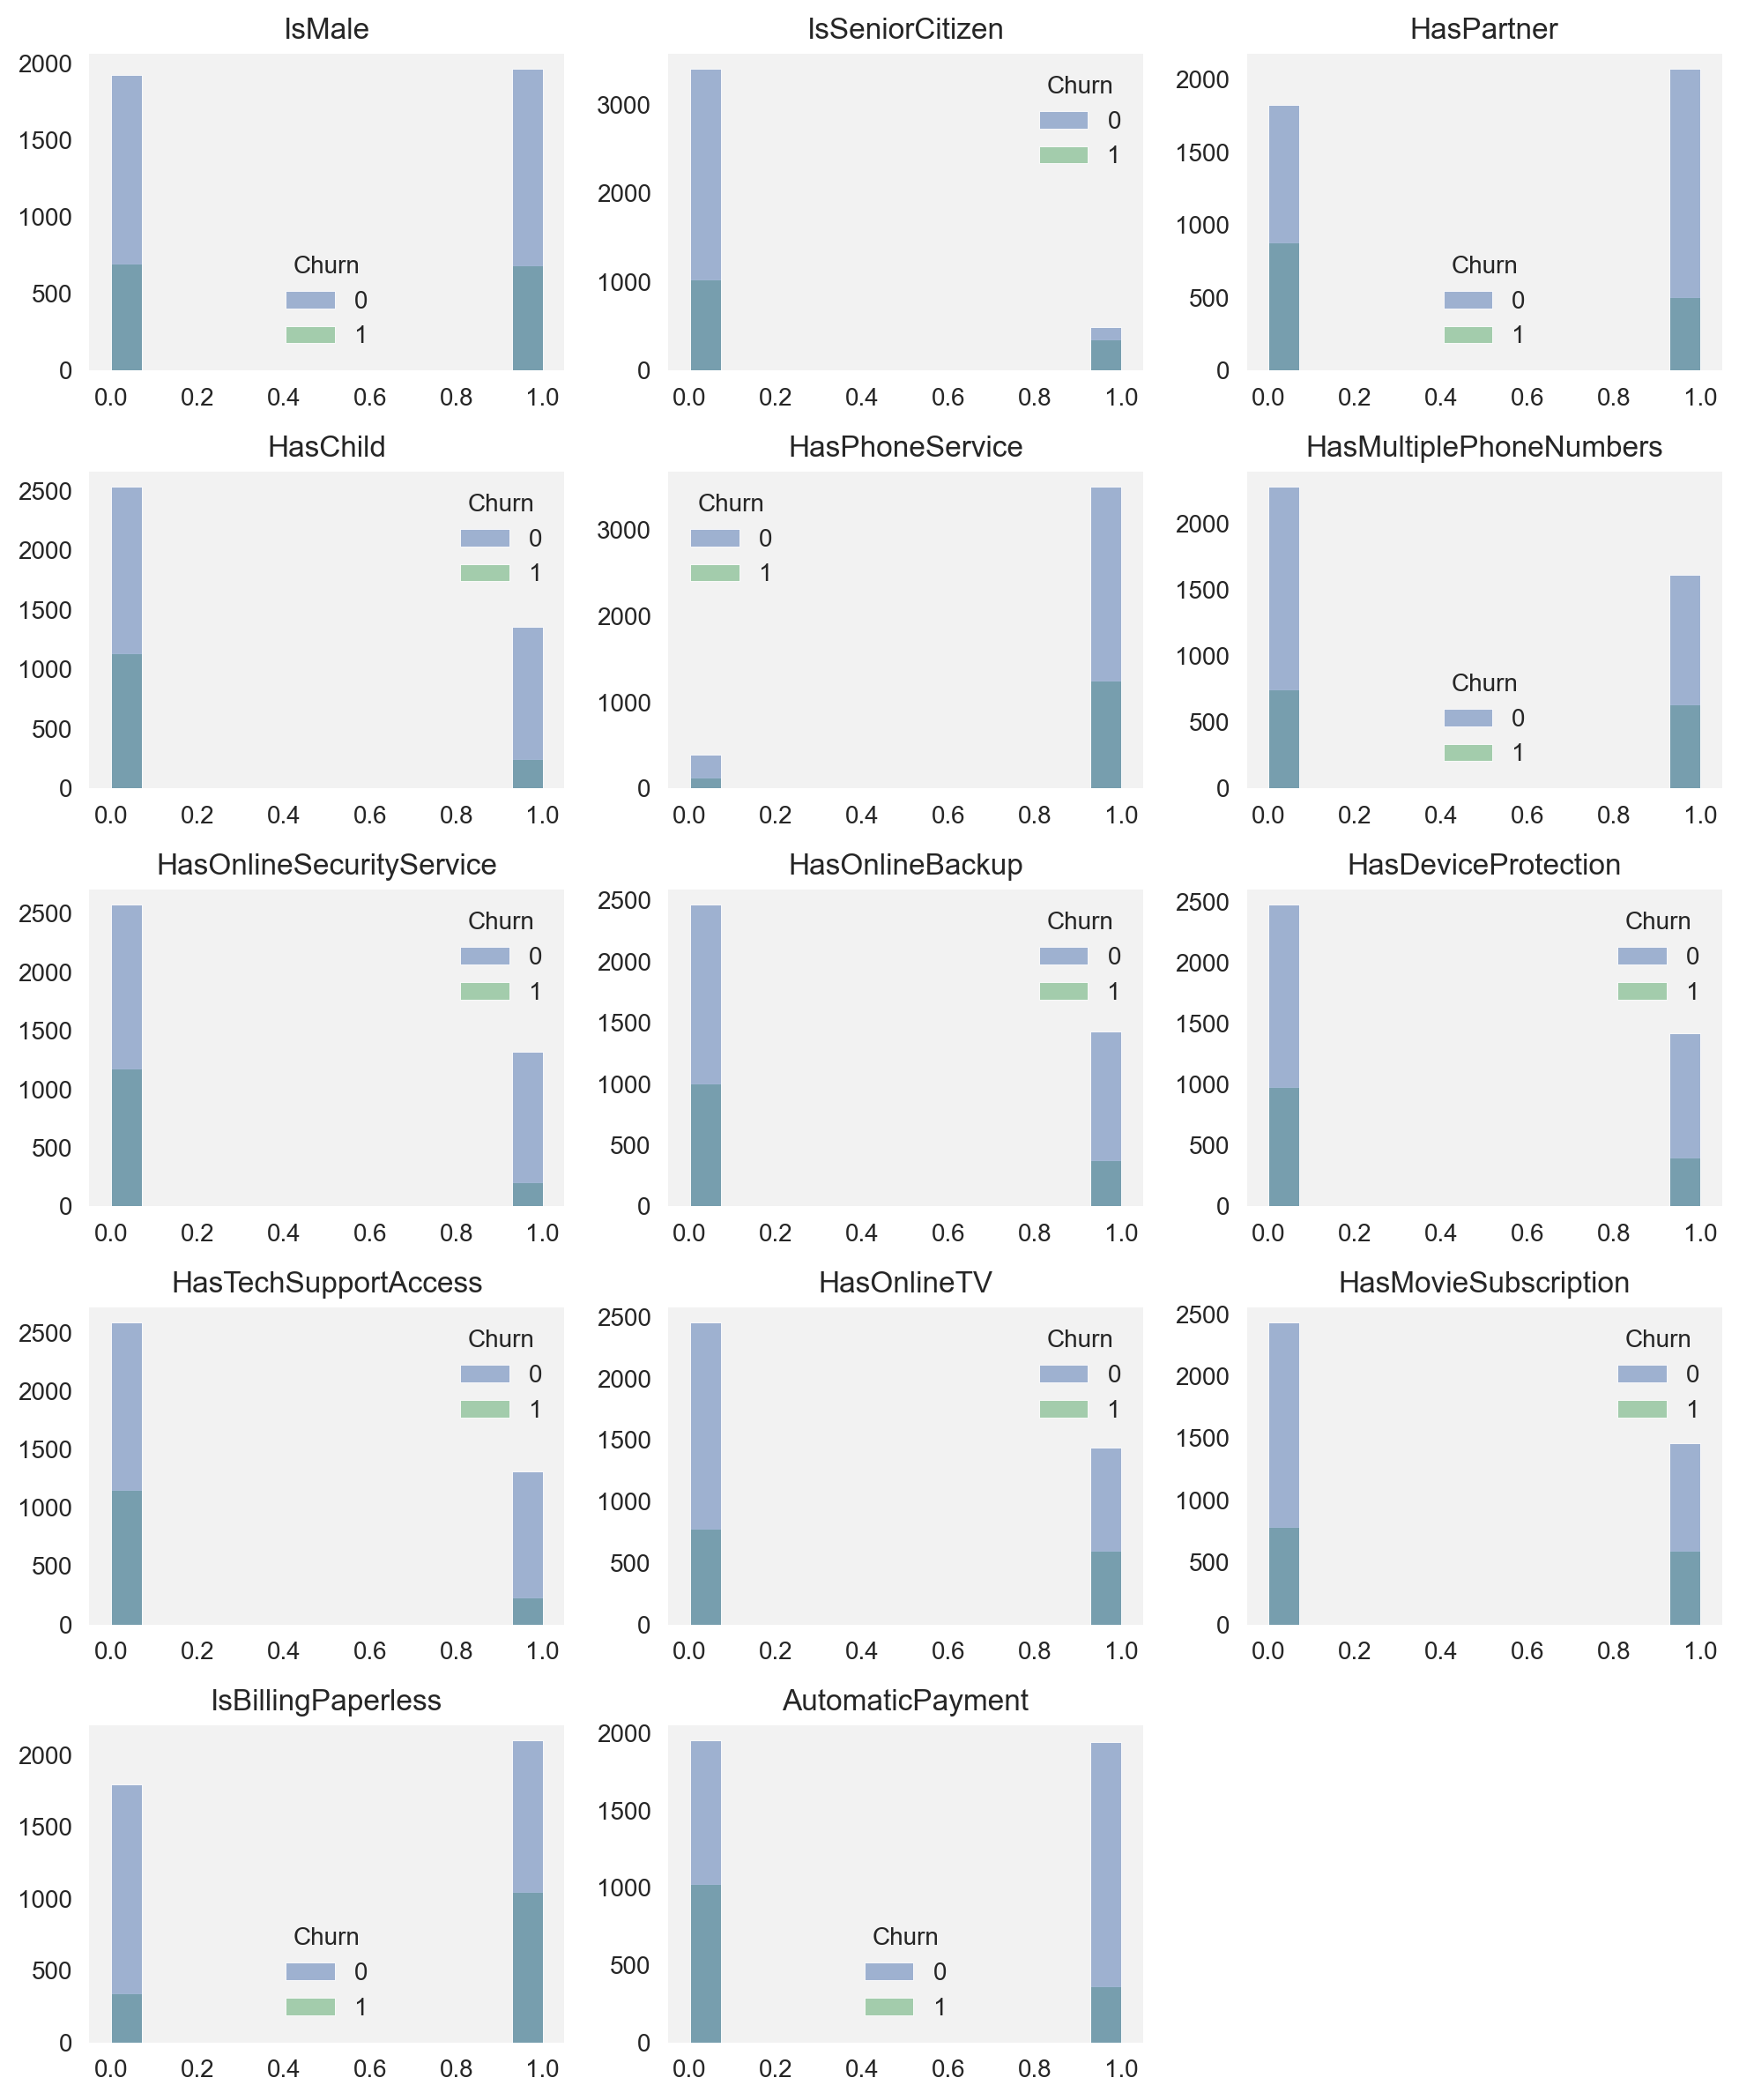

In [26]:
# создаем лист бинарных признаков
bin_cols = [
    col
    for col in cat_cols
    if col not in ["PaymentMethod", "HasContractPhone", "HasInternetService"]
]

plt.figure(figsize=(10, 12))

cnt = 1
for col in bin_cols:
    plt.subplot(5, 3, cnt)
    sns.histplot(data=train, x=col, hue="Churn")
    plt.xlabel("")
    plt.ylabel("")
    plt.title(col)
    cnt += 1

plt.tight_layout()

Часть признаков потребует классововй балансировки при разбиении на обучающую и валидационную выборки.

### Остальные категориальные признаки

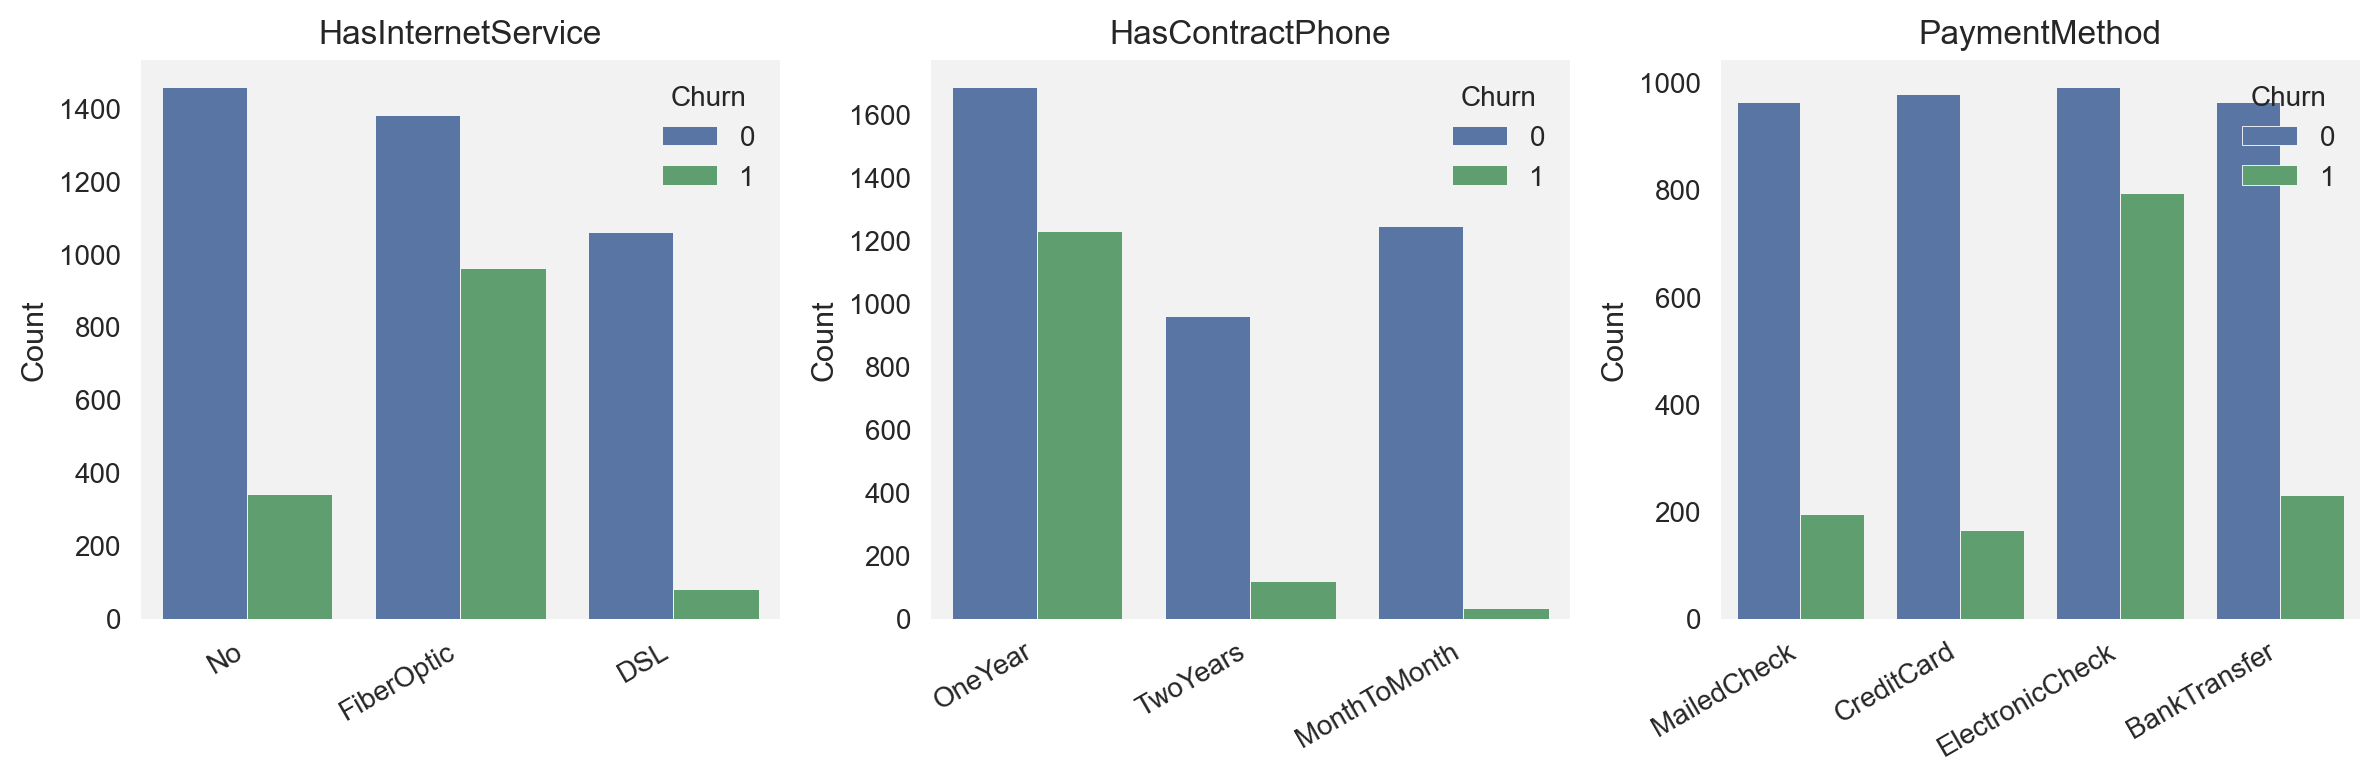

In [27]:
# составить списко оставшихся признаков
non_bin_cols = [col for col in cat_cols if col not in bin_cols]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, col in enumerate(non_bin_cols):

    tmp = train.groupby([col, "Churn"], as_index=False).agg(Count=("Churn", "count"))
    sns.barplot(data=tmp, x=col, y="Count", hue="Churn", ax=ax[i])
    ax[i].set_xticklabels(train[col].unique(), rotation=30, horizontalalignment="right")
    ax[i].set(title=col, xlabel="")

plt.tight_layout()

Среди оттекших клиентов есть явный дисбаланс в сторону тех, кто имеет:
1. DSL интерент соединение;
2. Годовой контракт;
3. Оплату методом электронного чека.

### $\phi_K$ корреляция признаков

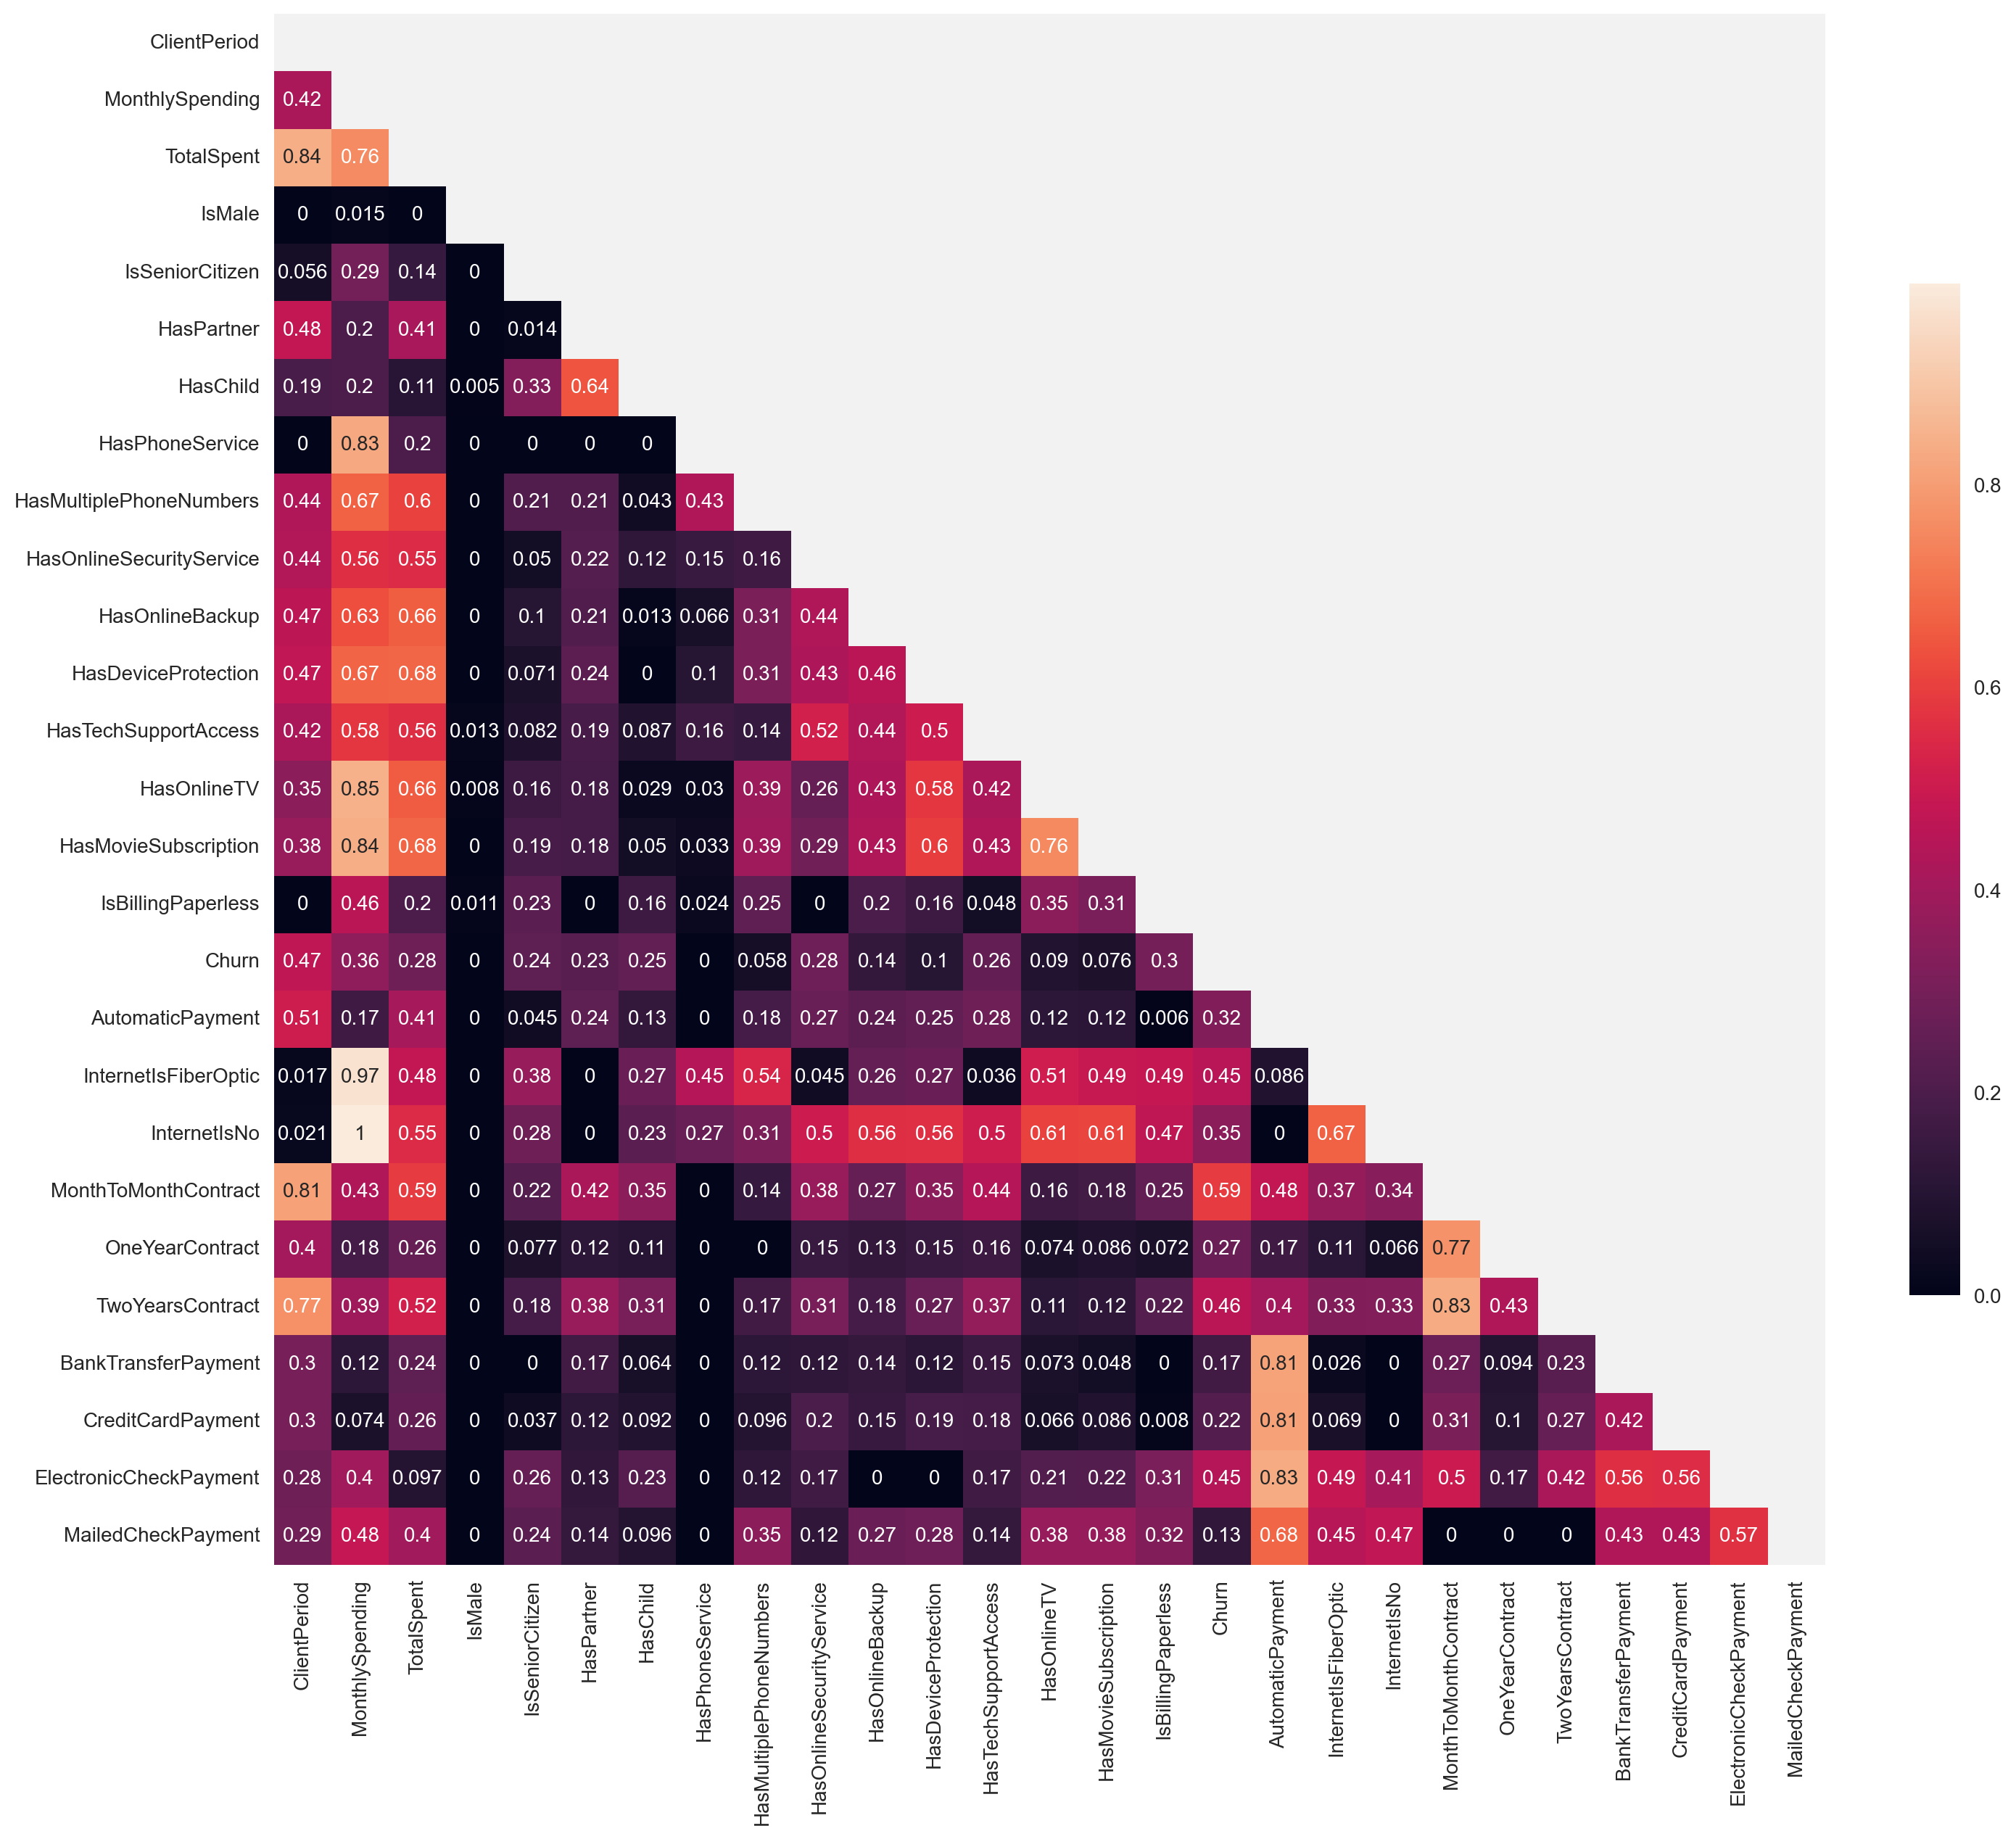

In [28]:
phik_matrix = train_ohe.phik_matrix(train_ohe.columns).round(3)

mask = np.triu(np.ones_like(phik_matrix, dtype=bool))
plt.figure(figsize=(15, 15))

heatmap = sns.heatmap(
    phik_matrix,
    annot=True,
    square=True,
    mask=mask,
    cbar_kws={"fraction": 0.03},
)

Из всех признаков, явно не коррелирует с остальными только гендер клиента (`IsMale`). Также,
слабо коррелируют с ключевой метрикой признаки касащиеся телефонной связи: `HasPhoneService`, `HasMultiplePhoneNumbers`, `HasOnlineBackup`, `HasDeviceProtection`,`HasOnlineTV`, `HasMovieSubscription`. Можно предположить, что их незначительная связь с изменением ключего признака может быть выражена через другие признаки, такие как ежемесячныя стоимость. Чтобы повысить эффективность обучения, можно попробовать исключить эти признки из обучающей выборки.

In [29]:
cols2drop = [
    "IsMale",
    "HasPhoneService",
    "HasMultiplePhoneNumbers",
    "HasOnlineBackup",
    "HasDeviceProtection",
    "HasOnlineTV",
    "HasMovieSubscription",
]

***

## Моделирование 

### Импорт библиотек

In [30]:
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score, roc_auc_score, roc_curve
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_predict,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder
from xgboost import XGBClassifier

### Переменные

In [31]:
# число для фиксации рандома
seed = 42

In [32]:
# признаки для стратификации
strat_labels = [
    "Churn",
    "IsSeniorCitizen",
    "HasChild",
    "HasOnlineSecurityService",
    "HasTechSupportAccess",
    "OneYearContract",
    "TwoYearsContract",
    "BankTransferPayment",
    "CreditCardPayment",
    "ElectronicCheckPayment",
    "MailedCheckPayment",
]

### Функции

In [33]:
# Показать ROC-кривую
def plot_auc(y_true, y_pred, model_name=None):

    curve = roc_curve(y_true, y_pred)[:2]
    score = roc_auc_score(y_true, y_pred)

    plt.plot(*curve, label=f"AUC: {score:.4f}")
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), c="gray")
    legend_box = plt.legend(framealpha=1).get_frame()
    legend_box.set_facecolor("black")
    legend_box.set_edgecolor("white")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    if model_name != None:
        plt.title(f"ROC AUC for {model_name}")
    plt.show()

In [34]:
# процедура оценки модели
def eval_model(
    model,
    data=train_ohe,
    target="Churn",
    strat_labels=strat_labels,
    scale_features=False,
    seed=seed,
):

    # используем многоклассовую стратификацию
    mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    scaler = MinMaxScaler()

    y_true = []
    y_pred = []

    for train_idx, valid_idx in tqdm(mskf.split(data, data[strat_labels])):

        X = data.drop("Churn", axis=1).values
        y = data["Churn"].values

        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        if scale_features:
            X_train = scaler.fit_transform(X_train)
            X_valid = scaler.transform(X_valid)

        model = model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_valid)[:, 1]

        y_true += list(y_valid)
        y_pred += list(y_proba)

    plot_auc(y_true, y_pred, model_name=type(model).__name__)

In [35]:
def optimize_df(df, dtype_float=np.float32, dtype_int=np.int16, show=False):
    "Takes in and returns a dataframe with data types optimized."

    types = list()
    for x in df.dtypes.tolist():
        if x == "int64":
            types.append(dtype_int)
        elif x == "float64":
            types.append(dtype_float)
        else:
            types.append("object")

    types = dict(zip(df.columns.tolist(), types))

    if show:
        display(pd.Series(types))

    return df.astype(types)

### Бейзлайн: LogisticRegression

Оценим работу базовой логистической регрессии используя стратифицируемую кросс-валидацию:

0it [00:00, ?it/s]

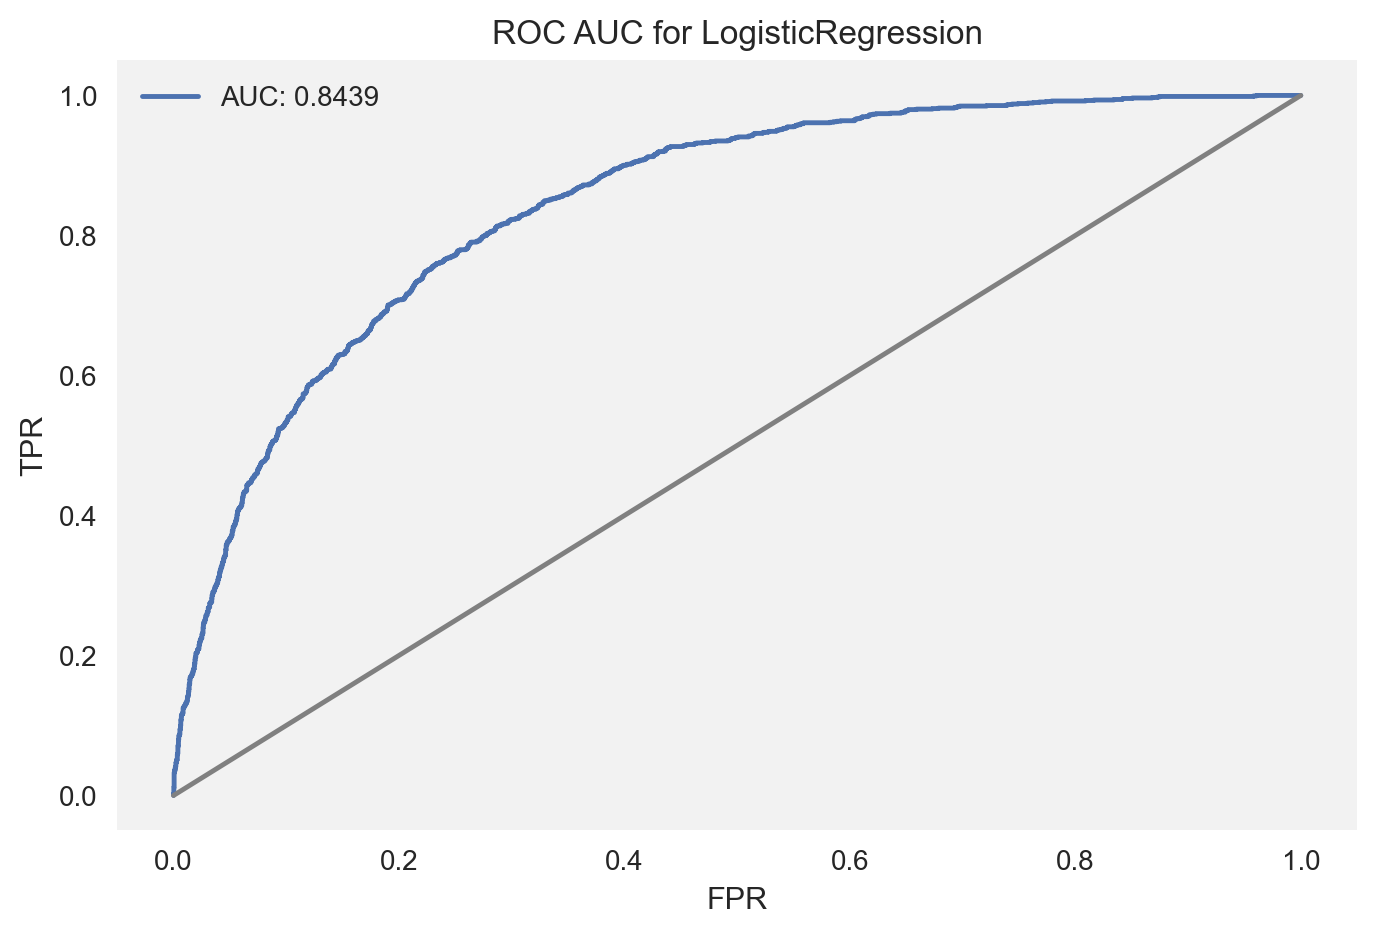

In [36]:
lr = LogisticRegression()
eval_model(lr, scale_features=True)

Хороший скор уже на базовой модели.

#### Feature engineering

Добавим eщё несколько  признаков на основе уже имеющихся данных

In [37]:
def add_new_features(df):
    # выделить новых клиентов
    func = lambda x: 1 if x < 4 else 0  # число подобрано «на ощупь»
    df["NewClient"] = df["ClientPeriod"].apply(func)

    df["TotalSpentLog"] = np.log(df["TotalSpent"])
    df["MonSpentLog"] = np.log1p(df["MonthlySpending"])
    df["TotalSpentMean"] = df["TotalSpent"] / (df["ClientPeriod"] + 1)

    return df

In [38]:
train_ohe = add_new_features(train_ohe)
strat_labels.append("NewClient") if "NewClient" not in strat_labels else None

0it [00:00, ?it/s]

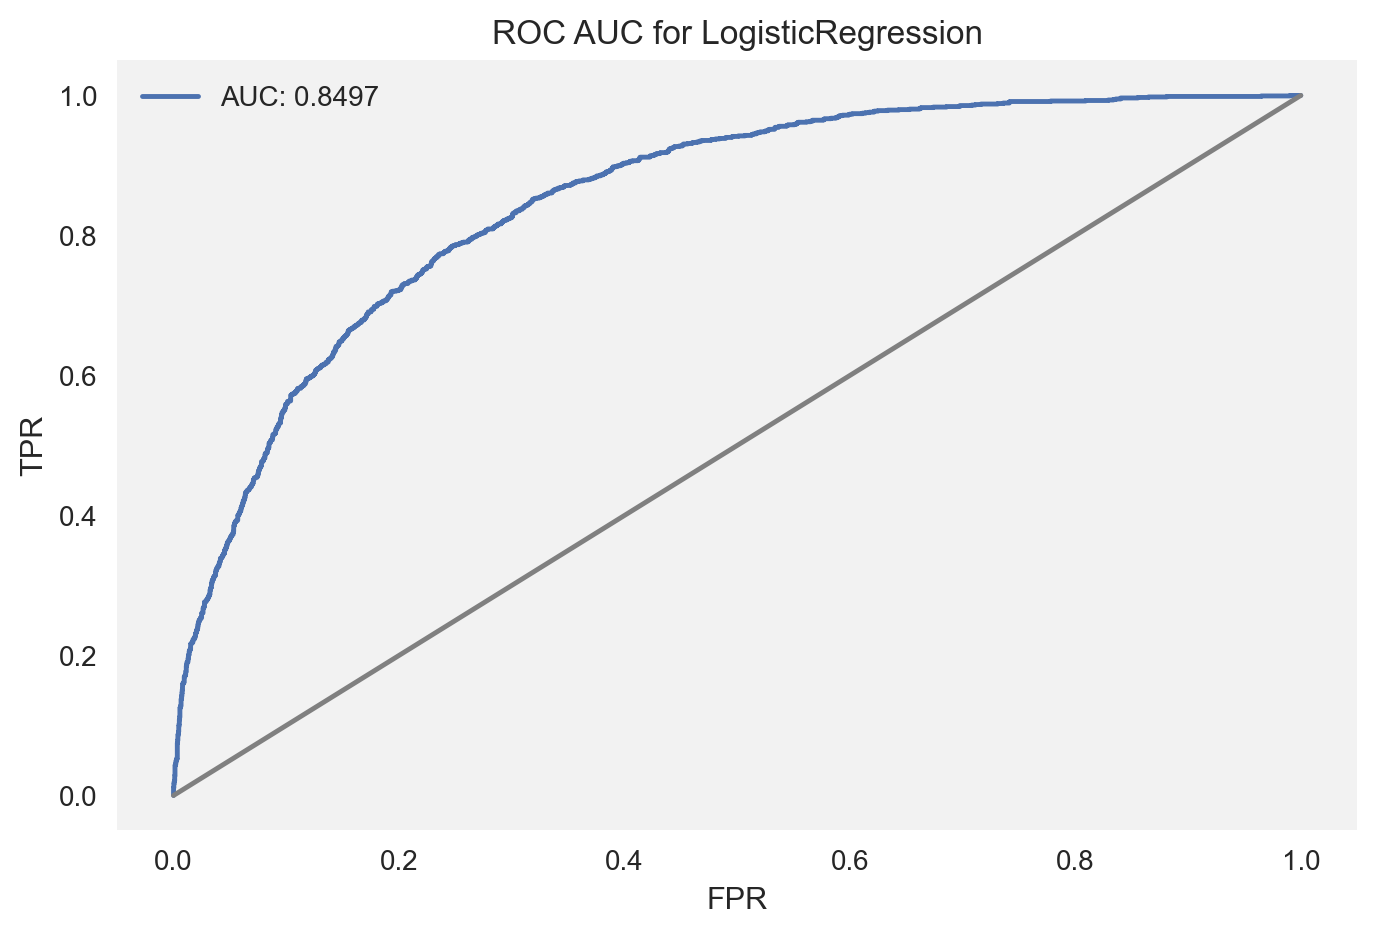

In [39]:
eval_model(lr, scale_features=True)

#### Оптимизация

Попробуем подобрать более оптимальное значение для `C` параметра при помощи GridSearch:

In [40]:
X = train_ohe.drop("Churn", axis=1)
y = train_ohe["Churn"].values

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
split = mskf.split(train_ohe, train_ohe[strat_labels])
scaler = MinMaxScaler()

model = LogisticRegression()
pipe = Pipeline(steps=[("scaler", scaler), ("model", model)])

param_grid = {
    "model__max_iter": [1000],
    "model__tol": [1e-5],
    "model__C": range(0, 200, 10),
    "model__penalty": ["l1", "l2", "elasticnet"],
}

search = GridSearchCV(pipe, param_grid, cv=split, n_jobs=-1, scoring="roc_auc")
search.fit(X, y)

print(
    "Best AUC: %0.4f" % search.best_score_,
    " for ",
    type(model).__name__,
    "with parameters: ",
)
print(search.best_params_)

Best AUC: 0.8504  for  LogisticRegression with parameters: 
{'model__C': 100, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__tol': 1e-05}


Получилось ещё немного улучшить скор. Проверим скоринг на лидерборде.

0it [00:00, ?it/s]

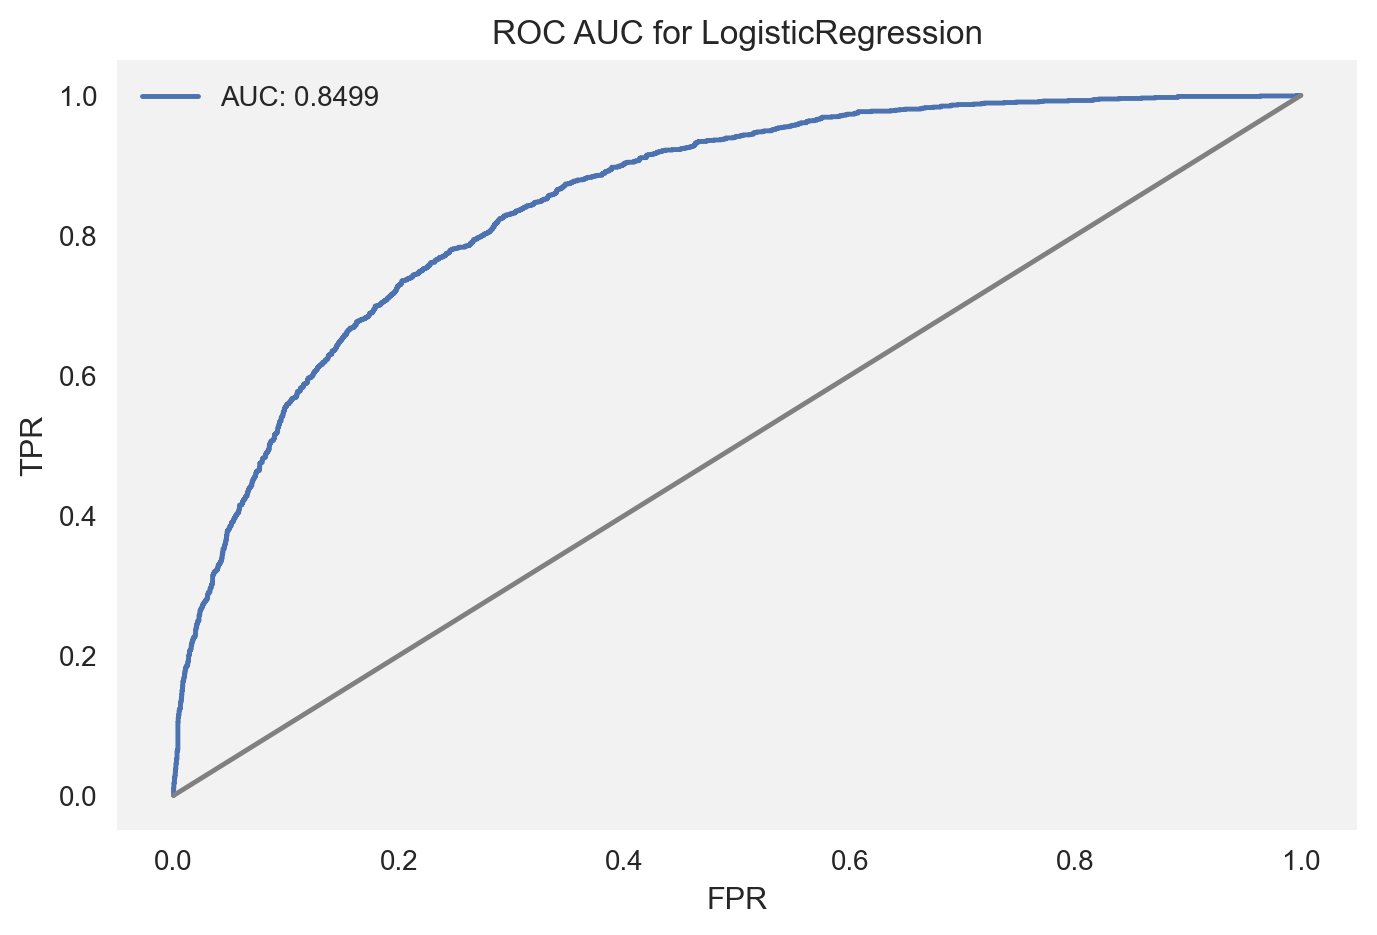

In [41]:
# используем моедль с лучшими параметрами
params = {i[7:]: search.best_params_[i] for i in search.best_params_}
best_lr = LogisticRegression(**params)

eval_model(best_lr, scale_features=True)

In [42]:
# добавим новые признаки в тестовую выбоку
test_ohe = add_new_features(test_ohe)

# обучим модель на полном наборе данных
best_lr.fit(X, y)
y_pred = best_lr.predict_proba(test_ohe)[:, 1]

sub_df = pd.DataFrame({"Id": test.index, "Churn": y_pred})
sub_df.to_csv("sub_LR.csv", index=False)

<img src="sub_LR.png">

### Градиентный бустинг

#### Подготовка данных

In [43]:
# добавим ordinal-кодирование для бустинговых алгоритмов
train_oe = add_new_features(train)
test_oe = add_new_features(test)

encoder = OrdinalEncoder()
train_oe[non_bin_cols] = encoder.fit_transform(train_oe[non_bin_cols]).astype(int)
test_oe[non_bin_cols] = encoder.transform(test_oe[non_bin_cols]).astype(int)

# сохранить данные в более экономоном для памяти формате
train_oe = optimize_df(train_oe, dtype_int=np.uint8, show=True)
test_oe = optimize_df(
    test_oe,
    dtype_int=np.uint8,
)

ClientPeriod                  <class 'numpy.uint8'>
MonthlySpending             <class 'numpy.float32'>
TotalSpent                  <class 'numpy.float32'>
IsMale                        <class 'numpy.uint8'>
IsSeniorCitizen               <class 'numpy.uint8'>
HasPartner                    <class 'numpy.uint8'>
HasChild                      <class 'numpy.uint8'>
HasPhoneService               <class 'numpy.uint8'>
HasMultiplePhoneNumbers       <class 'numpy.uint8'>
HasInternetService            <class 'numpy.uint8'>
HasOnlineSecurityService      <class 'numpy.uint8'>
HasOnlineBackup               <class 'numpy.uint8'>
HasDeviceProtection           <class 'numpy.uint8'>
HasTechSupportAccess          <class 'numpy.uint8'>
HasOnlineTV                   <class 'numpy.uint8'>
HasMovieSubscription          <class 'numpy.uint8'>
HasContractPhone              <class 'numpy.uint8'>
IsBillingPaperless            <class 'numpy.uint8'>
PaymentMethod                 <class 'numpy.uint8'>
Churn       

In [44]:
# обновим список признаков для стратификации
strat_labels_trees = [
    "Churn",
    "IsSeniorCitizen",
    "HasChild",
    "HasOnlineSecurityService",
    "HasTechSupportAccess",
    "NewClient",
    "HasInternetService",
    "HasContractPhone",
    "PaymentMethod",
]

#### Xgoost

0it [00:00, ?it/s]

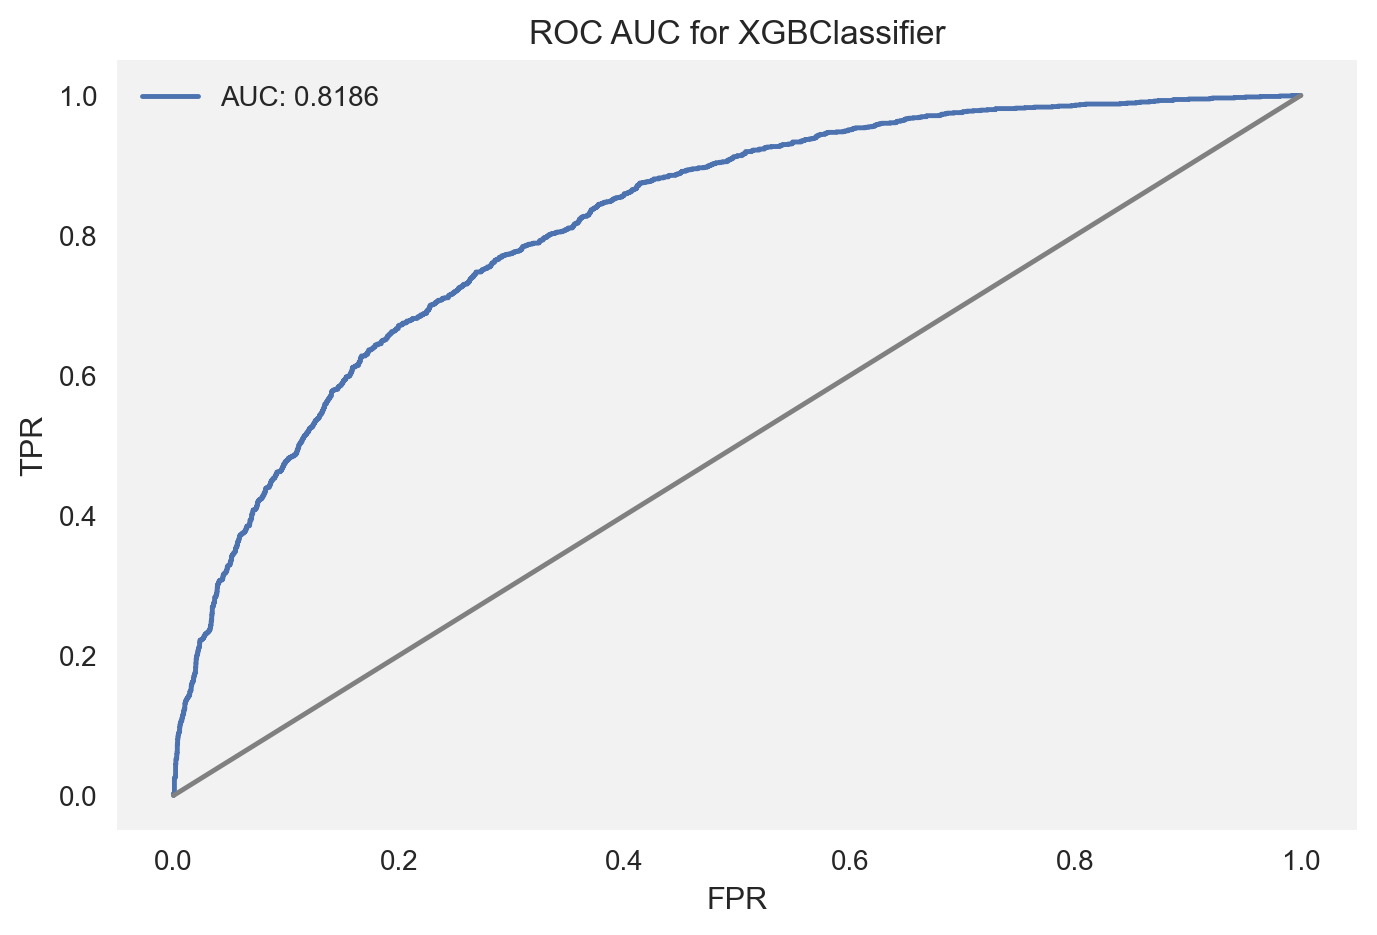

In [45]:
# базовая модель
xgb = XGBClassifier(random_state=seed)
eval_model(xgb, data=train_oe, strat_labels=strat_labels_trees)

Базовая модель хуже чем LogisticRegression. Посмотрим можно ли добиться улучшения побдром гиперпараметров.

In [ ]:
X = train_oe.drop("Churn", axis=1)
y = train_oe["Churn"].values

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
split = mskf.split(train_oe, train_oe[strat_labels_trees])
scaler = MinMaxScaler()

param_grid = {
    "model__n_estimators": range(100, 1001, 5),
    "model__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
    "model__random_state": [seed],
    "model__booster": ["gbtree", "gblinear", "dart"],
}

model = XGBClassifier()
pipe = Pipeline(steps=[("scaler", scaler), ("model", model)])

search = RandomizedSearchCV(
    pipe, param_grid, cv=split, n_jobs=-1, scoring="roc_auc", random_state=seed
)

search.fit(X, y)

print(
    "Best AUC: %0.4f" % search.best_score_,
    " for ",
    type(model).__name__,
    "with parameters: ",
)
print(search.best_params_)

In [ ]:
params = {i[7:]: search.best_params_[i] for i in search.best_params_}
best_xgb = XGBClassifier(**params)

eval_model(best_xgb, data=train_oe, strat_labels=strat_labels_trees)

Не так хорошо, как логистическая регрессия, но гораздо лучше чем базовый XGBoost.

#### LightGBM

In [ ]:
lgbm = LGBMClassifier(random_state=seed)
eval_model(lgbm, data=train_oe, strat_labels=strat_labels_trees)

Подберем лучшие гиперпараметры.

In [ ]:
split = mskf.split(train_oe, train_oe[strat_labels_trees])
scaler = MinMaxScaler()

param_grid = {
    "model__boosting_type": ["gbdt", "dart"],
    "model__n_estimators": range(10, 2001, 10),
    "model__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
    "model__max_depth": range(1, 20, 1),
    "model__num_leaves": range(1, 201, 1),
    "model__subsample": np.arange(0.75, 1, 0.01).round(3),
    "model__random_state": [seed],
}

model = LGBMClassifier()
pipe = Pipeline(steps=[("scaler", scaler), ("model", model)])

search = RandomizedSearchCV(
    pipe, param_grid, cv=split, n_jobs=-1, scoring="roc_auc", random_state=seed
)

search.fit(X, y)

print(
    "Best AUC: %0.4f" % search.best_score_,
    " for ",
    type(model).__name__,
    "with parameters: ",
)
print(search.best_params_)

In [ ]:
params = {i[7:]: search.best_params_[i] for i in search.best_params_}
best_lgbm = LGBMClassifier(**params)

eval_model(best_lgbm, data=train_oe, strat_labels=strat_labels_trees)

Есть улучшение по отношению к базовому LGBM, но скоринг логистической регрессии все ещё не побит.

#### CatBoost

In [ ]:
cat = CatBoostClassifier(random_seed=seed, custom_metric=["AUC"], verbose=False)
eval_model(cat, data=train_oe, strat_labels=strat_labels_trees)

Попробуем подобрать лучшие гиперпараметры.

In [ ]:
split = mskf.split(train_oe, train_oe[strat_labels_trees])
scaler = MinMaxScaler()

param_grid = {
    "model__random_state": [seed],
    "model__verbose": [False],
    "model__iterations": range(100, 2001, 100),
    "model__learning_rate": np.arange(0.01, 0.16, 0.01).round(3),
    "model__max_depth": range(1, 10, 1),
    "model__subsample": np.arange(0.75, 1, 0.01).round(3),
    "model__l2_leaf_reg": range(1, 20, 1),
}

model = CatBoostClassifier()
pipe = Pipeline(steps=[("scaler", scaler), ("model", model)])

search = RandomizedSearchCV(
    pipe, param_grid, cv=split, n_jobs=-1, scoring="roc_auc", random_state=seed
)

search.fit(X, y)

print(
    "Best AUC: %0.4f" % search.best_score_,
    " for ",
    type(model).__name__,
    "with parameters: ",
)
print(search.best_params_)

In [ ]:
params = {i[7:]: search.best_params_[i] for i in search.best_params_}
best_cat = CatBoostClassifier(**params)

eval_model(best_cat, data=train_oe, strat_labels=strat_labels_trees)

Лучший скор все равно не побит.

### Голосование

Попробуем добиться лучшего скора используя самые «уверенные» предсказания от всех алгоритмов.

In [ ]:
X_train = train_oe.drop("Churn", axis=1).values
y_train = train_oe["Churn"].values
X_test = test_oe.values

models = [best_lr, best_xgb, best_lgbm, best_cat]

preds = []
for model in models:
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]
    preds.append(proba)

In [ ]:
pred_matrix = np.array(preds).T

ids = np.argmax(abs(pred_matrix - 0.5), axis=1)
most_conf = [pred_matrix[i, arg] for i, arg in enumerate(ids)]

sub_df["Churn"] = most_conf
sub_df.to_csv("sub_voting.csv", index=False)

<img src="sub_voting.png">

Хоть и совсем немного, но получилось поднять скор по отношению к базовой модели.

***